# Сначала переводим изображение в бинарное

In [1]:
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def convert_images(root, destination, type):
    images_list = os.listdir(os.path.join(root, type))
    classes = {
        0: 0,
        210: 0,
        496: 0,
        162: 0,
        300: 0,
        459: 0,
        441: 1,
        320: 0,
        511: 0,
        284: 0,
        255: 0,
        360: 0,
        440: 0
    }
    for image in images_list:
        image_np = np.array(Image.open(os.path.join(root, type, image)))
        image_np = image_np.sum(axis=2)
        labels_image = np.zeros((image_np.shape[0], image_np.shape[1]),dtype=np.uint8)
        for key, value in classes.items():
            labels_image[np.where(image_np == key)] = value

        np.savez(os.path.join(destination, image), labels_image)


segmented_dir = r"C:\Users\Slava\Documents\test"
destination = r"C:\Users\Slava\Documents\test\img2"
convert_images(segmented_dir, destination, "img")



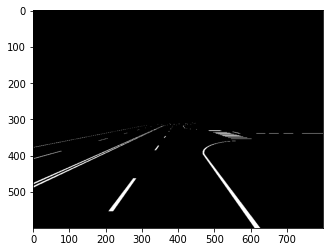

In [2]:
os.path.join(segmented_dir, "img")
img_primal = np.load(destination + "\\1.png.npz")["arr_0"]
plt.imshow(img_primal,cmap ="gray") # Show results
plt.show()

# Bird view преобразование, по факту сужаем нижнюю часть

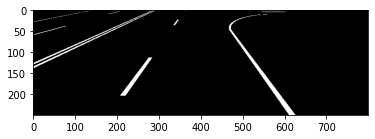

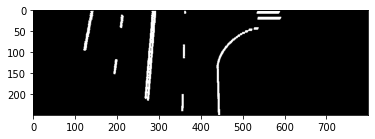

In [3]:
img = cv2.imread('1.png') # Read the test img


IMAGE_H = 600
IMAGE_W = 800
img = img_primal[int(IMAGE_H * 2/4 + 50):(IMAGE_H), 0:IMAGE_W] # Apply np slicing for ROI crop
IMAGE_H= IMAGE_H - int(IMAGE_H *2/4 + 50) 

#src = np.float32([ [351, 320], [417, 320], [536, 485],[0,485]]) 
src = np.float32([[0,0],[IMAGE_W,0],[400+80,IMAGE_H],[400 - 80, IMAGE_H]]) 
dst = np.float32([[0, 0],[IMAGE_W, 0], [IMAGE_W, IMAGE_H],[0,IMAGE_H]])

#for point in src:
#    point = np.int32(point)
#    img = cv2.circle(img,point,20,(0,255,0),thickness=-1)
    
#for point in dst:
#    point = np.int32(point)
#    img = cv2.circle(img,point,10,(0,0,255),thickness=-1)
    
    
plt.imshow(img,cmap ='gray') # Show results
plt.show()

M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation
warped_img = cv2.warpPerspective(img, Minv, (IMAGE_W, IMAGE_H)) # Image warping

kernel = np.ones((3, 3), 'uint8')
warped_img = cv2.dilate(warped_img, kernel, iterations=1)

plt.imshow(warped_img,cmap ='gray') # Show results
plt.show()

# Применяем метод связных компонент 

In [4]:
output = cv2.connectedComponentsWithStats(warped_img)
(numLabels, labels, stats, centroids) = output


# Полученные сегменты:
## * Фильтруем по площади, убирая откровенно мелкие детали
## * Выделяем 2 точки у вершины сегмента, в дальнейшем "голова"
## TO DO выделить и хвосты + Проверять на выход за пределы изображения

124 88 123 93


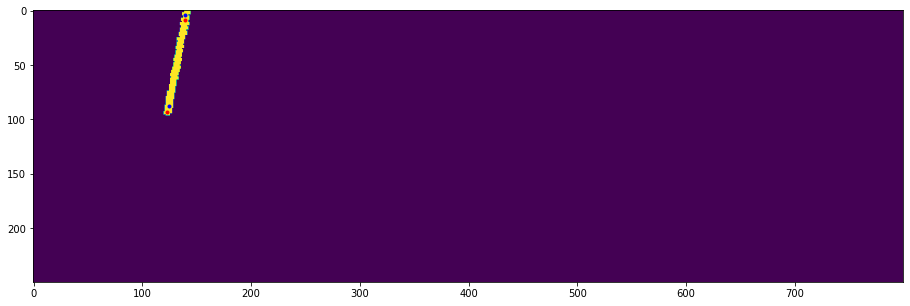

272 201 271 206


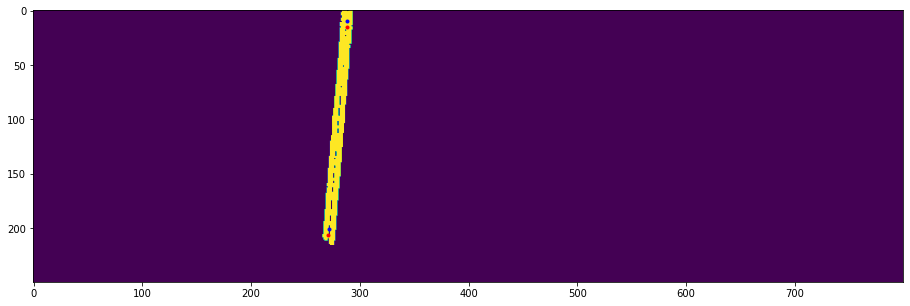

363 6 363 7


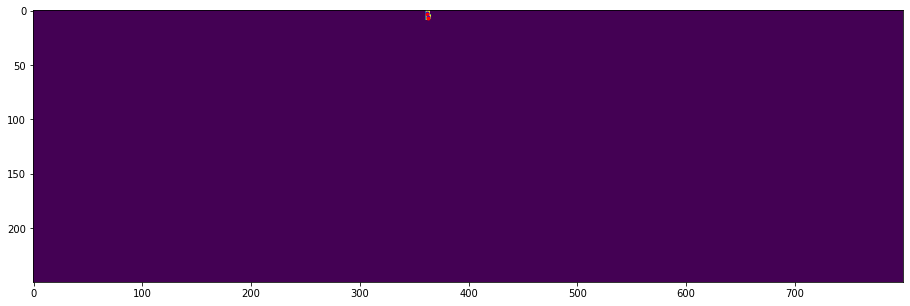

561 6 560 7


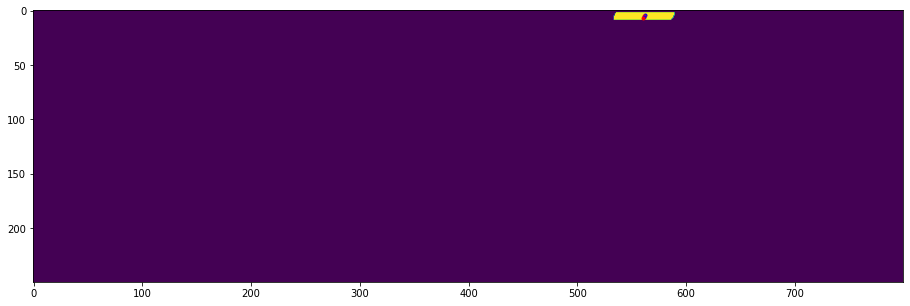

210 36 210 41


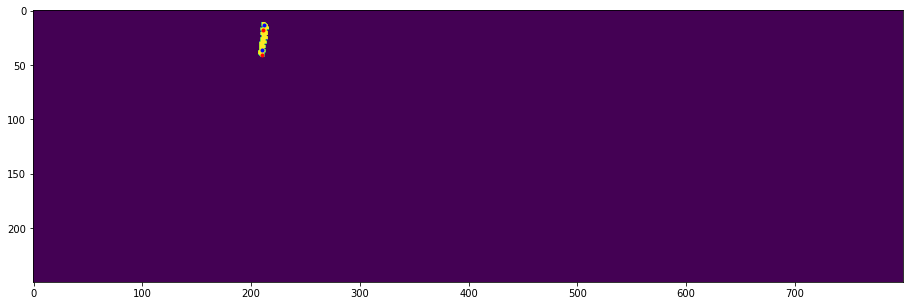

563 20 563 21


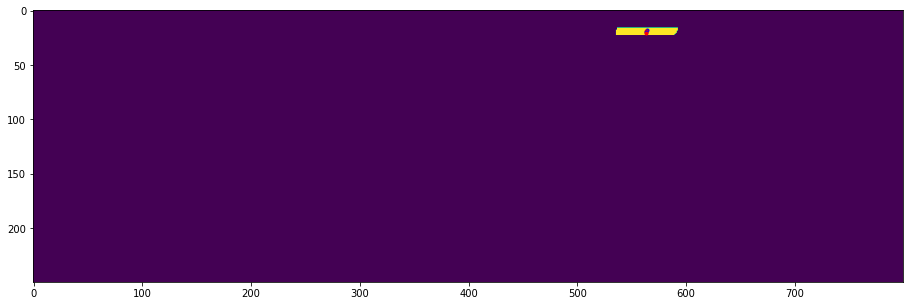

443 235 443 240


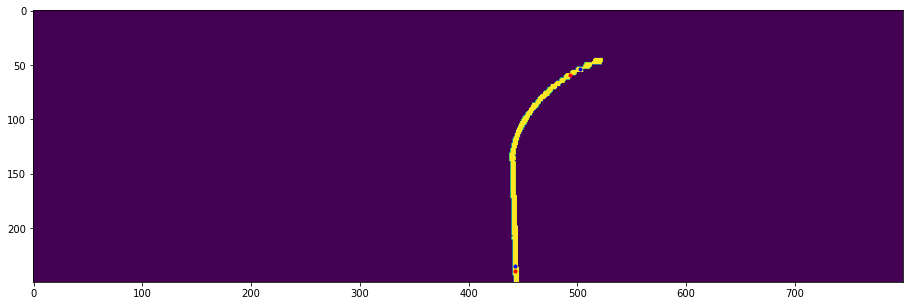

360 108 360 113


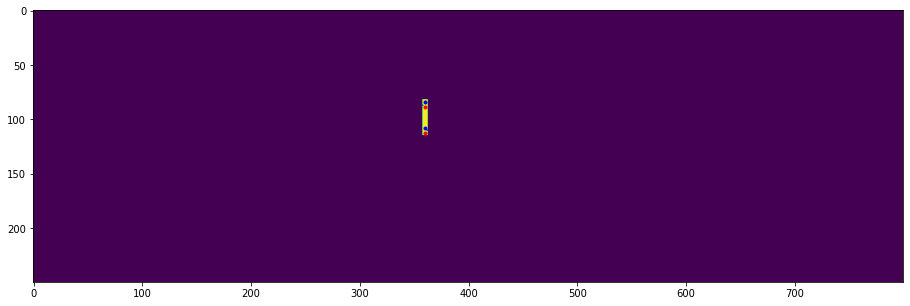

194 146 194 151


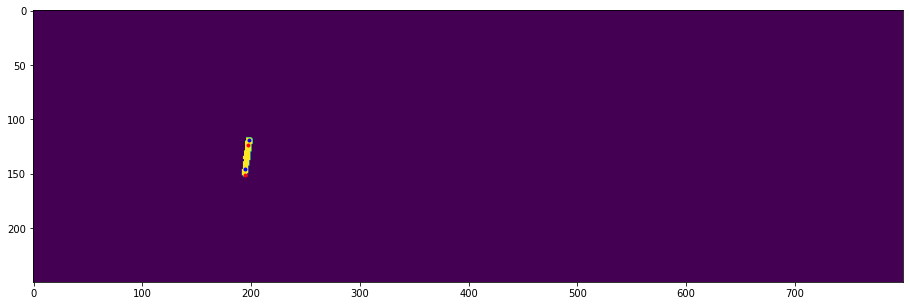

356 234 356 239


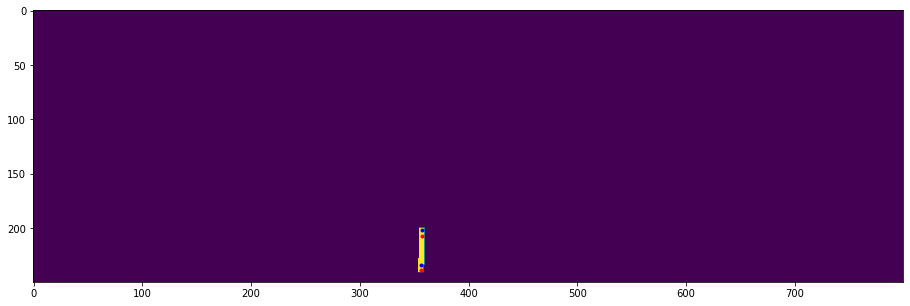

In [5]:
def getMeanXpoint(img,x,y,w,index = 255):
    res, = np.where(img[y, x : x + w] == index)
    res = res + x
    if(len(res) == 0):
        return None,None,None
    else:
        return int(np.mean(res)), min(res), max(res) 


labels_index = list();
segment_points =dict();
for i in range(1,numLabels):    
    
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    
    
    #ПРОВЕРИТЬ ПРОВЕРИТЬ ПРОВЕРИТЬ проверку
    if h >= 7: ## тут удаляем малые обьекты h >= y_shift + max(h_segment) 
        
        y_shift = max(2,int(0.05 * h))
        h_segment = min(int(0.2 * h),5)
        
        y_head_top = y + y_shift
        y_head_bot = y + h_segment + y_shift
        
        x_head_top_mean = getMeanXpoint(labels,x,y_head_top,w,i)[0]
        x_head_bot_mean = getMeanXpoint(labels,x,y_head_bot,w,i)[0]
        
        y_tail_top = y + h - h_segment - y_shift
        y_tail_bot = y + h - y_shift
        
        x_tail_top_mean = getMeanXpoint(labels,x,y_tail_top,w,i)[0]
        x_tail_bot_mean = getMeanXpoint(labels,x,y_tail_bot,w,i)[0]
        
        segment_points[i]  = (x_head_top_mean, y_head_top, x_head_bot_mean, y_head_bot,
                             x_tail_top_mean, y_tail_top, x_tail_bot_mean, y_tail_bot)
        labels_index.append(i)
        
        # тут проверка, но кажется изза метода связных компонент она излишня
        #if(x_head_top_mean != None) & (x_head_bot_mean != None) & (x_tail_top_mean != None) & (x_tail_bot_mean != None):
        #    segment_points[i]  = (x_head_top_mean, y_head_top, x_head_bot_mean, y_head_bot)
        #    labels_index.append(i)

###printing
plt.rcParams["figure.figsize"] = (30,5)
for i in labels_index:
    componentMask = (labels == i).astype("uint8") * 255
    plt.imshow(componentMask)
    
    x0,y0,x1,y1,x2,y2,x3,y3 = segment_points[i]
    print(x2,y2,x3,y3)
    plt.plot(x0,y0, color='blue', marker='o',markersize = 3)
    plt.plot(x1,y1, color='red', marker='o',markersize = 3)
    plt.plot(x2,y2, color='blue', marker='o',markersize = 3)
    plt.plot(x3,y3, color='red', marker='o',markersize = 3)
    plt.show()

In [6]:
labels_index

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

# Находим расстояния от прямых головы до точек хвоста (пока что до головы)
# Находим углы между прямыми головы и хвоста(пока головы)

In [7]:
labels_count = len(labels_index)

def angleBetween(k1,k2):
    return abs(np.arctan((k2 - k1) / (1 + k1 * k2)))

def getB_coeff(x1,y1,x2,y2):
    return - (x2 - x1)/(y2 - y1) 

def getC_coeff(x1,y1,x2,y2):
    return - x1 + y1 * (x2 - x1)/(y2 - y1)

def getAll_coeff(x1,y1,x2,y2):
    return (1, getB_coeff(x1,y1,x2,y2), getC_coeff(x1,y1,x2,y2))

def getDistance(x,y,A,B,C,R):
    return abs(A * x + B * y + C) / R

sqrt = np.sqrt


connected_segments = [set([labels_index[i]]) for i in range(0,labels_count)]

for i in range(0,labels_count):
    label_index1 = labels_index[i] 
    x1,y1,x2,y2,*v = segment_points[label_index1]
    
    A12,B12,C12 = getAll_coeff(x1,y1,x2,y2)
    
    R12 = np.linalg.norm([A12,B12])
    
    for j in range(i + 1,labels_count):
        label_index2 = labels_index[j] 
        x3,y3,x4,y4,*b = segment_points[label_index2]
        
        A34,B34,C34 = getAll_coeff(x3,y3,x4,y4)
        R34 = np.linalg.norm([A34,B34])
        
        d12_3 = getDistance(x3,y3,A12,B12,C12,R12)
        d12_4 = getDistance(x4,y4,A12,B12,C12,R12)
        d34_1 = getDistance(x1,y1,A34,B34,C34,R34)
        d34_2 = getDistance(x2,y2,A34,B34,C34,R34)
        dist_g = [d12_3,d12_4,d34_1,d34_2]
        
        #print(label_index1,label_index2,d12_3,d12_4,d34_1,d34_2)
        
        B12 = B12
        B13 = getB_coeff(x1,y1,x3,y3)
        B14 = getB_coeff(x1,y1,x4,y4)
        B24 = getB_coeff(x2,y2,x4,y4)
        B34 = getB_coeff(x3,y3,x4,y4)
        
        dist_r = [None]*4
        dist_r[0] = angleBetween(B12,B13)
        dist_r[1] = angleBetween(B12,B14)
        dist_r[2] = angleBetween(B34,B14)
        dist_r[3] = angleBetween(B34,B24)
        
        #print(label_index1,label_index2,d12_3,d12_4, np.mean(alpha))
        mean_dir = np.mean(dist_r)
        mean_geo = np.mean([d12_3,d12_4,d34_1,d34_2])
        var_dir = np.var(dist_r)
        var_geo = np.var([d12_3,d12_4,d34_1,d34_2])
        
        new_dist_r = [(dist_r[k] - mean_dir) / sqrt(var_dir) * sqrt(var_geo) + mean_geo for k in range(0,4) ]
        cost = np.mean([(dist_g[k] + new_dist_r[k])/2 for k in range(0,4)])
        
# соединяем множества номеров сегментов      
        segment_group_index1, segment_group_index2 = 0,0
        if cost < 30:
            #print(label_index1,label_index2)
            for k in range(len(connected_segments)):
                segment_group = connected_segments[k]
                
                if label_index1 in segment_group:
                    segment_group_index1 = k
                if label_index2 in segment_group:
                    segment_group_index2 = k
                    
            if(segment_group_index1 != segment_group_index2):
                connected_segments[segment_group_index1] = connected_segments[segment_group_index1].union(connected_segments[segment_group_index2])
                connected_segments.pop(segment_group_index2)
                
            
        print(label_index1,label_index2,cost)

1 2 149.0
1 3 223.0
1 4 nan
1 5 72.67857210191767
1 6 366.57605499396396
1 8 288.15542731680824
1 9 221.0
1 10 69.208662534405
1 11 218.0
2 3 74.0
2 4 230.61842520251417
2 5 75.46303664247043
2 6 237.27527945200657
2 8 174.85255711563556
2 9 72.0
2 10 78.9329462099831
2 11 69.0
3 4 170.99100820454467
3 5 147.76394096734356
3 6 177.64786245403704
3 8 124.25455504263384
3 9 2.0
3 10 151.2338505348562
3 11 5.0
4 5 290.3775789137708
4 6 11.31370849898476
4 8 11.430156068563045
4 9 142.99963017589621
4 10 254.32057654670228
4 11 103.84099025766974
5 6 298.3878267849214
5 8 231.6105807131703
5 9 154.02023796745635
5 10 7.060180864974641
5 11 162.6202189270728
6 8 10.482266454026032
6 9 149.65648442538858
6 10 262.3308244178529
6 11 110.49784450716211
8 9 89.02559237670789
8 10 185.14965516449186
8 11 100.82122251769488
9 10 157.49014753496905
9 11 3.0
10 11 166.09012849458549


C:\Users\Slava\AppData\Local\Temp\ipykernel_264\2890202050.py:7: RuntimeWarning: divide by zero encountered in int_scalars
  return - (x2 - x1)/(y2 - y1)
C:\Users\Slava\AppData\Local\Temp\ipykernel_264\2890202050.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return abs(np.arctan((k2 - k1) / (1 + k1 * k2)))


In [8]:
connected_segments

[{1}, {2}, {3, 9, 11}, {4, 6, 8}, {5, 10}]

## Каждый классифицированный сегмент разбиваем на точки для фита
Точки выбираются путем среденго по Х, затем у каждого сегмента удаляются те точки которые лежат за -sigma, что гарантирует что все точки лежат на жирной прямой а не на кончиках сегмента.

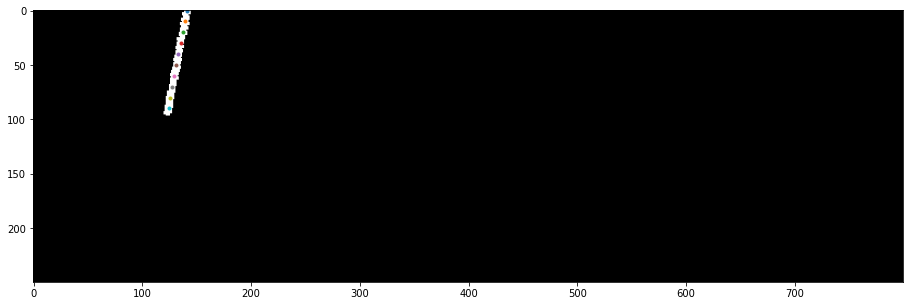

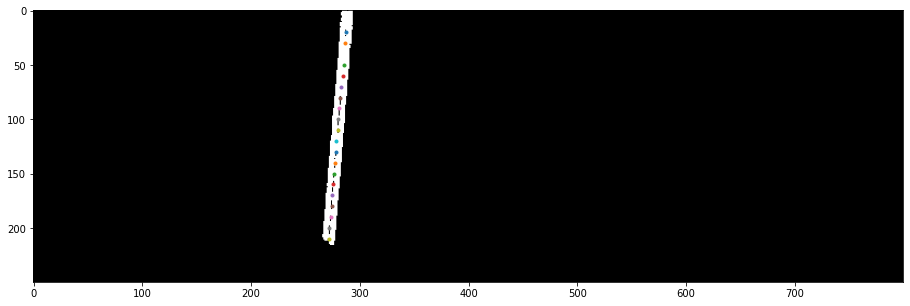

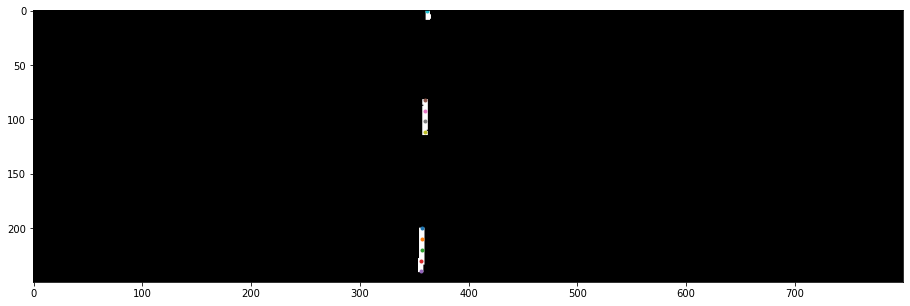

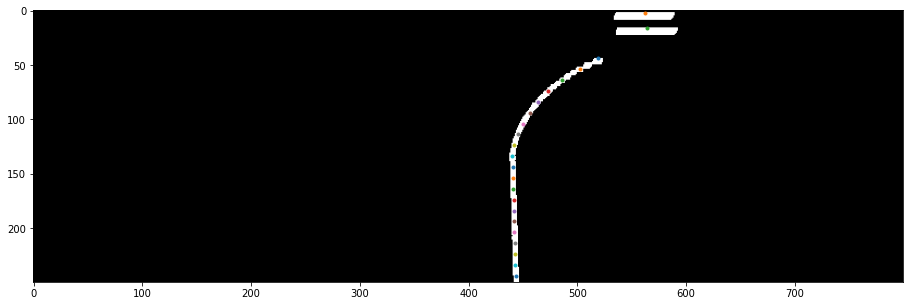

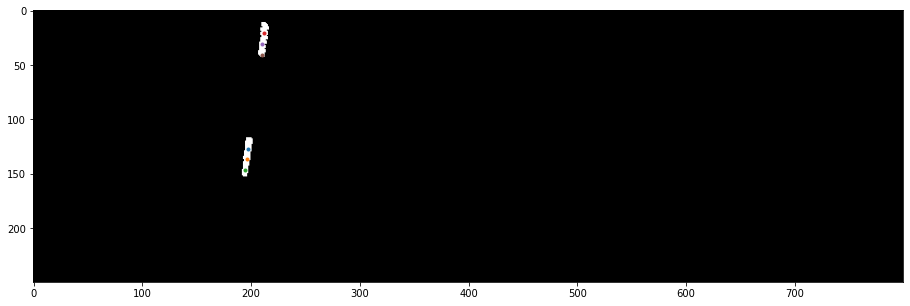

In [9]:
# принимает карту, начальная точка (x,y), ширину w, сравниваем все точки с index
def getMeanXpoint(img,x,y,w,index = 255):
    
        res, = np.where(img[y, x : x + w] == index)
        res = res + x
        if(len(res) == 0):
            return None,None,None
        else:
            #print(res,int(np.mean(res)))
            return int(np.mean(res)), min(res), max(res)    


segments_linePoints = dict()

for connected_segment_indexes in connected_segments:
    
#### for ploting
    res = np.zeros(labels.shape,dtype = bool) 
    for index in connected_segment_indexes:
        res = np.logical_or(res,labels == index)


    
    for index in connected_segment_indexes:
        segments_linePoints[index] = list()
        x_left = stats[index, cv2.CC_STAT_LEFT]
        y = stats[index, cv2.CC_STAT_TOP]
        w = stats[index, cv2.CC_STAT_WIDTH]
        h = stats[index, cv2.CC_STAT_HEIGHT]
        

        dy = max(10, h // 20) # фитить 
        
        newY = y
        buffer = list()
        while(newY < y + h):
            x_mean, x_min, x_max = getMeanXpoint(labels,x_left,newY,w,index)
            
            if(x_mean == None):
                continue
            buffer.append(((x_mean,newY),x_max - x_min))
            
            #segments_linePoints[index].append((x_mean,newY)) # решение без std
            #plt.plot(x_mean,newY,marker='o',markersize = 3)
            newY += dy
        
        line_width = [ line_w for point, line_w in buffer]
        sigma = np.std(line_width)
        mean = np.mean(line_width)
        segments_linePoints[index] = list([point for point, line_width in buffer if line_width - mean >= -sigma])
        
        
        
        
        
#####ploting
        #print(segments_linePoints[index])
        #print(line_width,mean,sigma,np.array(line_width) - mean > - sigma)
        for point in segments_linePoints[index]:
            x,y = point
            plt.plot(x,y,marker='o',markersize = 3)
    
    res = res.astype("uint8") * 255
    plt.imshow(res,cmap ="gray")
    plt.show()



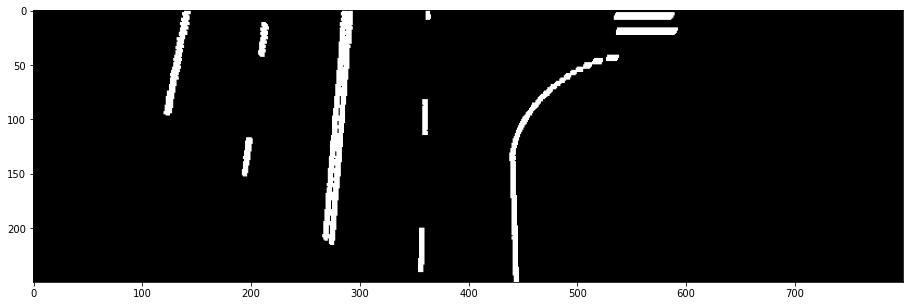

In [10]:
plt.imshow(warped_img,cmap ='gray') # Show results
plt.show()

In [11]:
connected_segments

[{1}, {2}, {3, 9, 11}, {4, 6, 8}, {5, 10}]

## Фитинг точек до кривых третьего порядка

[0.17622378] 0.41979015736885816
[1.58272524] 1.258064082714302
[0.54971765] 0.7414294671543422
[716.44138697] 26.76642275249728
[0.92429463] 0.9614024264846092


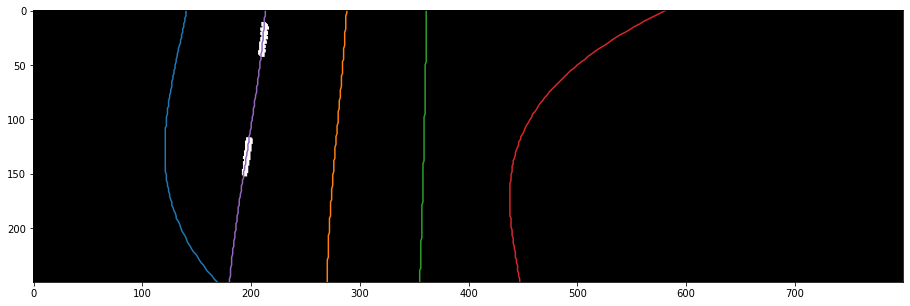

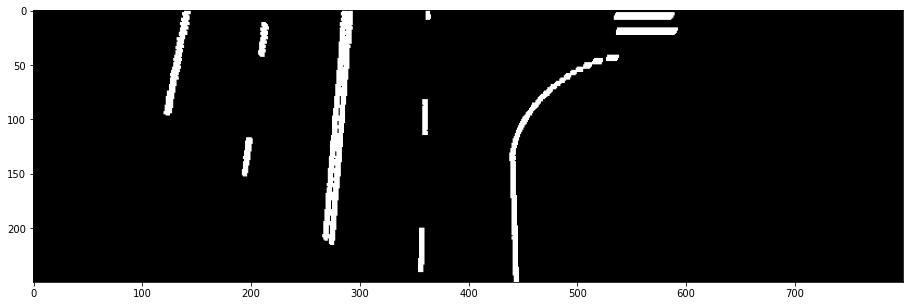

In [12]:
segments_lineCoef = list()
for connected_segment_indexes in connected_segments:
    
    #определяем размерность проблемы
    shape_j = 0
    for index in connected_segment_indexes:
        shape_j +=len(segments_linePoints[index])
    
    A = np.zeros((shape_j,4))
    Y = np.zeros((shape_j,1))# for plotting
    X = np.zeros((shape_j,1))

    # Для каждого связанного сегмента строим матрицу A и X, по точкам
    j = 0
    for index in connected_segment_indexes:
        for i in range(len(segments_linePoints[index])):
            x,y = segments_linePoints[index][i]
            
            A[j] = [y**3,y**2,y,1]
            Y[j] = y # for plotting
            X[j] = x
            j += 1
    
    # Фитинг + остаток
    coefs,residual = np.linalg.lstsq(A,X,rcond=-1)[0:2]
    segments_lineCoef.append(coefs)
    
############# for plotting############
    
    res = np.zeros(labels.shape,dtype = bool) #for plot
    for index in connected_segment_indexes:
        res = np.logical_or(res,labels == index) #for plot
    linApprox = lambda y: np.array([y**3,y**2,y,1]) @ coefs
    
    Y_approx = np.linspace(0,IMAGE_H,100,dtype = int)
    X_approx = np.array([linApprox(x) for x in Y[:,0]],dtype = int)
    X_approx2 = np.array([linApprox(x) for x in Y_approx],dtype = int)
    
    
    plt.plot(X_approx2,Y_approx)
    
    print(residual,np.linalg.norm(X - A @ coefs))
    res = res.astype("uint8") * 255
    plt.imshow(res,cmap ="gray")
plt.show()
plt.imshow(warped_img,cmap ='gray') # Show results
plt.show()

## Класиификация по кривым

### Отсев:
1) Вырезаем кривые которые пересекают остальные кривые (раметка параллельная)

2) Оставляем только те линии которые пересекают низ фотографии (разметка начинается снизу)

### Текущие классификации:
1) Все кривые интегрируются в боксе своего сегмента, если длина полученного отрезка больше эталона то это прямая

2) По дефолту все классы это деши

In [13]:
import scipy.integrate as integrate


#return dv - единичную длину кривой 3го порядка (требует интегрирования)
def getLen_of_line(x,coefs):
    a,b,c,d = coefs
    return ((3 * a * x**2 + 2 * b * x + c)**2 + 1)**(1/2)


#классы разметок
isDash, isLine, isDoubleLine, isNone = 1,2,3,10


#Просто часто используются
countOfLines = len(connected_segments)
segments_classification = [isDash] * countOfLines

y0 = 0
Y_Top = np.array([y0**3,y0**2,y0,1])
ybot = IMAGE_H
Y_Bot = np.array([ybot**3,ybot**2,ybot,1])


#########Вырезаем тех кто пересекает остальных###############

segments_intersection = [set() for x in range(countOfLines)]
for i in range(countOfLines):
    lineCoefs_first = segments_lineCoef[i]
    for j in range(i+1,countOfLines):
        lineCoefs_second = segments_lineCoef[j]

        x1_top = Y_Top @ lineCoefs_first
        x1_bot = Y_Bot @ lineCoefs_first

        x2_top = Y_Top @ lineCoefs_second
        x2_bot = Y_Bot @ lineCoefs_second

        if (x1_top < x2_top) ^ (x1_bot < x2_bot): # детектировано пересечение
            segments_intersection[i].add(j)
            segments_intersection[j].add(i)

lenOfSets = np.array([ len(intersection_set) for intersection_set in segments_intersection])
maxCount_intersections = max(lenOfSets)
while maxCount_intersections > 0:
    
    indexes = np.where(lenOfSets == maxCount_intersections)[0]
    for index in indexes:
        segments_intersection[index] = set()
        segments_classification[index] = isNone
        
    for intersection_set in segments_intersection:
        for index in indexes:
            intersection_set.discard(index)
            
    lenOfSets = np.array([ len(intersection_set) for intersection_set in segments_intersection])
    maxCount_intersections = max(lenOfSets)

###########линия должна начинаться внизу экрана############
for i in range(countOfLines):
    coefs = segments_lineCoef[i]
    currentType = segments_classification[i]

    

    Y = np.array([ybot**3, ybot**2, ybot, 1])
    x = Y @ coefs
    if (x < 0) | (IMAGE_W < x):
        currentType = max(currentType,isNone)
        segments_classification[i] = currentType
    
##########после отсева классифицируем##########
for i in range(countOfLines):
    coefs = segments_lineCoef[i]
    connected_segment_indexes = connected_segments[i]
    currentType = segments_classification[i]
    
    if(currentType != isNone):
        for index in connected_segment_indexes:

            #длина линии в прямоугольнике сегмента, в классе прямой должен быть длинный сегмент
            y = stats[index, cv2.CC_STAT_TOP]
            h = stats[index, cv2.CC_STAT_HEIGHT]

            integral = abs(integrate.quad(lambda x: getLen_of_line(x,coefs), y, y+h,limit = 10)[0])

            if(integral > 50):
                currentType = max(currentType,isLine)
            #print(index,integral)    
    segments_classification[i] = currentType

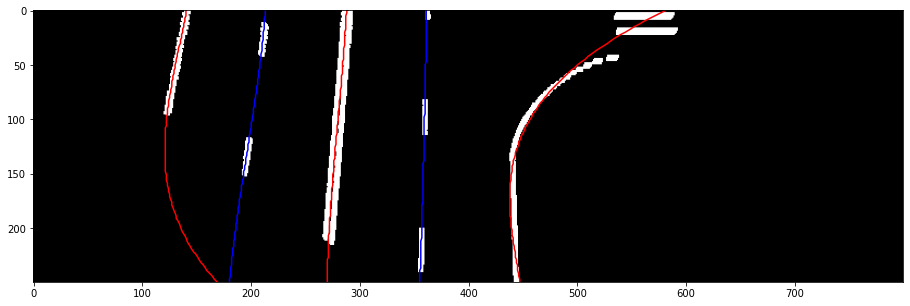

In [14]:
for classification, coefs in zip(segments_classification,segments_lineCoef):
    if(classification != isNone):
        linApprox = lambda y: np.array([y**3,y**2,y,1]) @ coefs
        Y_approx = np.linspace(0,IMAGE_H,100,dtype = int)    
        X_approx = np.array([linApprox(x) for x in Y_approx],dtype = int)
        color = 'blue' if(classification == isDash) else "red" 
        plt.plot(X_approx,Y_approx,color =color)
    
plt.imshow(warped_img,cmap ='gray') # Show results
plt.show()